# Case Study 3 - Heart Diseases

## Data Preprocessing (10 points)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1. Load data (0 points)

In [4]:
df = pd.read_csv('3_heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [5]:
df.shape

(1025, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


2. Check data description for missing values. If yes, mention how many and in which features. (5 points)

In [7]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


The data does not contain missing values.

3. Drop irrelevant features for the clustering process. (5 points)

In [8]:
df_clean = df.drop('target', axis=1)
df_clean.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2


I dropped the target column because the field refers to the presence of heart disease in the patient and doesn't contribute to clustering.

## Feature Selection (20 points)

1. Select your top 5 variables from all available variables. (10 points)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.metrics import accuracy_score, classification_report

In [10]:
X = df_clean
y = df['target']

In [11]:
# Preprocessing
num_tf = Pipeline([
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer([
    ("num", num_tf, X.columns)
])

In [12]:
# SelectKBest and Logistic Regression
selector_filter = SelectKBest(score_func=f_classif, k=5)

pipe_filter = Pipeline([
    ("prep", preprocess),
    ("sel", selector_filter),
    ("clf", LogisticRegression(max_iter=1000))
])

In [13]:
# Training and Evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

pipe_filter.fit(X_train, y_train)
pred = pipe_filter.predict(X_test)
print("=== Filter (ANOVA) + LR ===")
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

=== Filter (ANOVA) + LR ===
Accuracy: 0.8048780487804879
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       100
           1       0.78      0.87      0.82       105

    accuracy                           0.80       205
   macro avg       0.81      0.80      0.80       205
weighted avg       0.81      0.80      0.80       205



In [27]:
# Features name after preprocess
feat_names = [name.replace("num__", "") for name in pipe_filter.named_steps["prep"].get_feature_names_out()]
print("Features:\n", feat_names)

# Selected features from SelectKBest
sel = pipe_filter.named_steps["sel"]
mask = sel.get_support()
selected_names = [feat_names[i] for i in range(len(feat_names)) if mask[i]]
selected_scores = sel.scores_[mask]

# Display
df_selected = pd.DataFrame({
    "Feature": selected_names,
    "ANOVA_Score": selected_scores
}).sort_values(by="ANOVA_Score", ascending=False)

print("\n=== Top 5 Features Based on ANOVA (SelectKBest) ===")
print(df_selected)

Features:
 ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

=== Top 5 Features Based on ANOVA (SelectKBest) ===
   Feature  ANOVA_Score
2    exang   225.328624
0       cp   208.676582
3  oldpeak   183.171126
1  thalach   181.200997
4       ca   141.317598


2. How did you select these 5 variables? Explain your reasoning. (10 points)

I use ANOVA F-test (f_classif) inside SelectKBest to determine the top 5 variables. ANOVA ranks all numerical features by how well they distinguish the target classes. The top 5 features with the highest F-scores were chosen as the most relevant predictors for the model.

## Clustering - 1 (30 points)

1. Create a cluster model using KMeans with the number of clusters from 1 to 10. (10 points)

In [15]:
from sklearn.cluster import KMeans

In [16]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2


In [17]:
X_scaled = StandardScaler().fit_transform(X)

In [18]:
sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

2. Create an elbow diagram, determine the best number of clusters according to the elbow method, and provide your reasoning. (10 points)

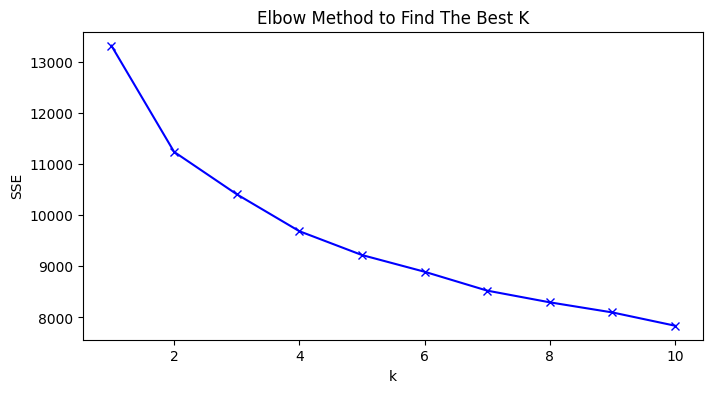

In [19]:
plt.figure(figsize=(8,4))
plt.plot(k_range, sse, "bx-")
plt.xlabel("k")
plt.ylabel("SSE")
plt.title("Elbow Method to Find The Best K")
plt.show()

Based on the elbow diagram, the SSE decreases sharply from k = 1 to k = 3, and then the curve starts to flatten after k = 3. So, the best number of clusters is k = 3, since this point represents the elbow of the curve.

3. Calculate the silhouette coefficient value for k=1 to k=10. Based on the silhouette value, what is the best number of clusters? Is it the same as the elbow method? (10 points)

In [20]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range_silhouette = range(2, 11) # Silhouette score is not defined for k=1
for k in k_range_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil_score)

print("Silhouette Scores for k=2 to 10:")
print(silhouette_scores)

Silhouette Scores for k=2 to 10:
[np.float64(0.1700813691485787), np.float64(0.12467708438804581), np.float64(0.13241276755337003), np.float64(0.1277045478827332), np.float64(0.12938491436347477), np.float64(0.1235473456043449), np.float64(0.11220659447943485), np.float64(0.11273483319899853), np.float64(0.11718274908856269)]


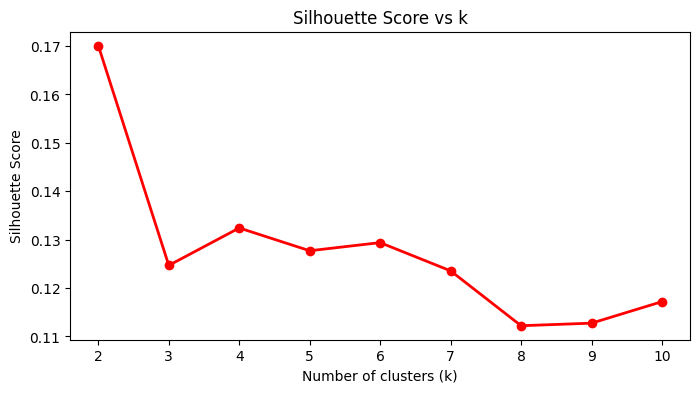

In [21]:
plt.figure(figsize=(8,4))
plt.plot(k_range_silhouette, silhouette_scores, 'ro-', linewidth=2)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.show()

The best number of clusters based on the Silhouette Coefficient is k = 2, as it provides the highest score of 0.17. However, the result different from the Elbow Method, which suggests k = 3. The difference occurs because the Elbow Method focuses on minimizing error (SSE), while the Silhouette Score measures the quality and separation of clusters.

## Clustering - 2 (20 points)



1. Create a cluster model using DBSCAN. How many clusters are produced? (10 points)

In [22]:
from sklearn.cluster import DBSCAN

eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_db = dbscan.fit_predict(X_scaled)

n_clusters = len(set(cluster_db)) - (1 if -1 in cluster_db else 0)
n_noise = list(cluster_db).count(-1)

print(f"DBSCAN clustering result:")
print(f"- eps = {eps}, min_samples = {min_samples}")
print(f"- Number of clusters: {n_clusters}")
print(f"- Number of noise points: {n_noise}")

DBSCAN clustering result:
- eps = 0.5, min_samples = 5
- Number of clusters: 3
- Number of noise points: 1005


The DBSCAN results produced 3 clusters and 1005 noise points when using eps value of 0.5 and min_sample of 5.

2. What are the silhouette coefficient and DBI values of the clusters produced by DBSCAN? (10 points)

In [23]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Silhouette score is not defined for noise points (-1)
silhouette = silhouette_score(X_scaled[cluster_db != -1], cluster_db[cluster_db != -1])

# DBI is not defined for noise points (-1)
if len(set(cluster_db[cluster_db != -1])) > 1:
    dbi = davies_bouldin_score(X_scaled[cluster_db != -1], cluster_db[cluster_db != -1])
else:
    dbi = "DBI is not defined for a single cluster (excluding noise)"

print(f"Silhouette Coefficient: {silhouette}")
print(f"Davies-Bouldin Index (DBI): {dbi}")

Silhouette Coefficient: 0.9675461485303419
Davies-Bouldin Index (DBI): 0.07465693262918326


From the DBSCAN, I got a silhouette coefficient of 0.968 and DBI of 0.075. It means the clusters are very well-separated, with points close to their own cluster and far from others. The low DBI also shows that the clusters are compact and well-separated.

## Feature Selection 2 (30 points)
After knowing the performance of the clustering results on the KMeans and DBSCAN models based on the silhouette coefficient and DBI, perform a feature selection process to improve the silhouette coefficient and DBI values. You are allowed to use an iterative process or other methods.

1. Which features provide the best silhouette coefficient/DBI values? Include the feature selection process.

In [29]:
from itertools import combinations

scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

subset_sizes = [5]  # features combination
results = []

for r in subset_sizes:
    for combo in combinations(X.columns, r):
        X_fs = scaled_df[list(combo)]

        # --- KMEANS ---
        km = KMeans(n_clusters=3, random_state=42)
        km_labels = km.fit_predict(X_fs)
        km_sil = silhouette_score(X_fs, km_labels)
        km_dbi = davies_bouldin_score(X_fs, km_labels)

        # --- DBSCAN ---
        db = DBSCAN(eps=0.3, min_samples=5)
        db_labels = db.fit_predict(X_fs)

        # pastikan DBSCAN punya > 1 cluster (selain -1)
        if len(set(db_labels)) > 1 and len(set(db_labels)) != 0:
            db_sil = silhouette_score(X_fs[db_labels != -1], db_labels[db_labels != -1])
            db_dbi = davies_bouldin_score(X_fs[db_labels != -1], db_labels[db_labels != -1])
        else:
            db_sil = float('nan')
            db_dbi = float('nan')

        results.append({
            'Features': combo,
            'KMeans_Silhouette': round(km_sil, 3),
            'KMeans_DBI': round(km_dbi, 3),
            'DBSCAN_Silhouette': round(db_sil, 3),
            'DBSCAN_DBI': round(db_dbi, 3)
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(
    by=['KMeans_Silhouette', 'DBSCAN_Silhouette'], ascending=[False, False]
).reset_index(drop=True)

print(results_df.head(5))

                             Features  KMeans_Silhouette  KMeans_DBI  \
0  (cp, fbs, thalach, exang, oldpeak)              0.371       1.128   
1  (fbs, thalach, exang, oldpeak, ca)              0.369       1.227   
2    (cp, fbs, thalach, exang, slope)              0.360       1.147   
3       (cp, fbs, thalach, exang, ca)              0.356       1.160   
4     (cp, fbs, exang, oldpeak, thal)              0.352       1.225   

   DBSCAN_Silhouette  DBSCAN_DBI  
0              0.492       0.502  
1              0.377       0.392  
2              0.595       0.396  
3              0.582       0.411  
4              0.698       0.304  


Based on the result, K-Means gives the best silhouette score of 0.371 and DBI of 1.128 using features (cp, fbs, thalach, exang, oldpeak). Meanwhile, DBSCAN performs better with a higher silhouette score of 0.698 and lower DBI of 0.304 using (cp, fbs, exang, oldpeak, thal). This means DBSCAN produces more compact and well-separated clusters, so it’s the better method in this case.

2. Why did you use that feature selection method?

I used iterative feature selection method because it allows us to test various feature combinations to find the best clustering performance based on silhouette and DBI values. By evaluating each subset, we can identify which features contribute most to forming clear and well-separated clusters, so it can produce more accurate clustering results.

## BONUS - CHALLENGE (30 points)
Build an ANNOY model using the data that has gone through the data preprocessing stage. Perform a query with the 5 nearest values. Does ANNOY query the best cluster you have formed?

In [25]:
!pip install annoy
import time
from annoy import AnnoyIndex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551808 sha256=293236020df075e5e6e7f4533a7b3e6202e0b823a2a2bda8011ffa09b37ccf5b
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


In [26]:
# Dimension
f = X_scaled.shape[1]

# Build ANNOY index
t = AnnoyIndex(f, 'euclidean')
for i, vec in enumerate(X_scaled):
    t.add_item(i, vec)

t.build(10) # 10 trees

# Define query point
query = X_scaled[0]

start = time.time()
idx_ann = t.get_nns_by_vector(query, 5)  # find 5 NN
time_ann = time.time() - start

print("Annoy NN index:", idx_ann)
print("Annoy NN distance:", [np.linalg.norm(X_scaled[i]-query) for i in idx_ann])
print("Time taken for Annoy:", round(time_ann*1000, 4), "ms")

Annoy NN index: [0, 634, 671, 863, 196]
Annoy NN distance: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(2.1119536676848902)]
Time taken for Annoy: 0.1478 ms


The ANNOY results show the closest neighbors [0, 634, 671, 863, 196] with almost all distances of 0.0, it means that these data points very similar to the query, except for the last one (2.11) which is slightly further away. This means that ANNOY successfully found points that are close in feature space. Since they most likely belong to the same cluster, these results match the best clusters formed previously.